<a href="https://colab.research.google.com/github/apchavezr/16.-Aprendizaje-Profundo-para-Ciencia-de-Datos/blob/main/LSTM_Prediccion_Nivel_Rio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de Series Temporales con LSTM: Nivel del Río Magdalena

Este cuaderno presenta una guía paso a paso para implementar una red LSTM en la predicción de series temporales, con enfoque en el monitoreo hidrológico. La idea es demostrar cómo modelar el nivel del río Magdalena utilizando datos históricos horarios o diarios.

> **Nota**: se utiliza una serie sintética como demostración. Para una implementación real, se recomienda descargar datos del IDEAM (https://www.ideam.gov.co/web/tiempo-y-clima/series-de-tiempo).

## Objetivo

Predecir el valor del nivel del río para el siguiente paso temporal (por ejemplo, 1 hora adelante), a partir de una ventana de 48 observaciones anteriores.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error


<ipython-input-2-4229334084>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fechas = pd.date_range(start='2020-01-01', periods=1000, freq='H')


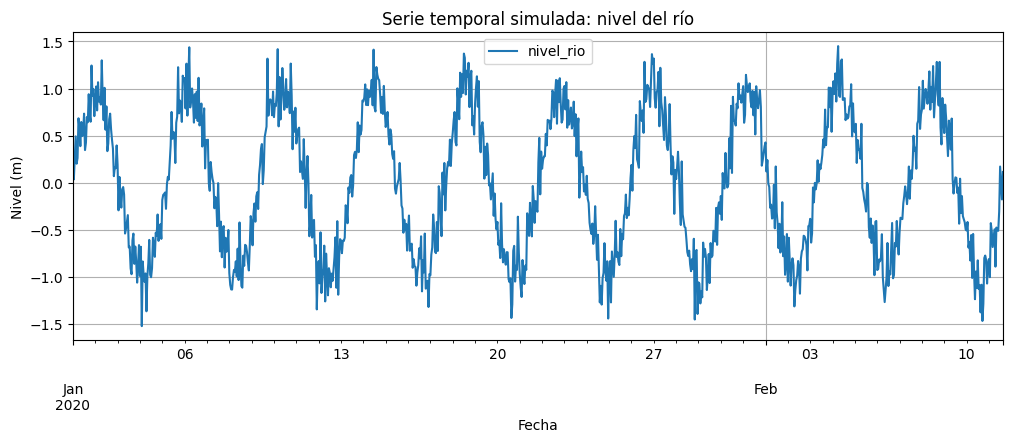

In [2]:
# Simulación de datos horarios
np.random.seed(42)
fechas = pd.date_range(start='2020-01-01', periods=1000, freq='H')
niveles = np.sin(np.linspace(0, 20 * np.pi, 1000)) + np.random.normal(scale=0.2, size=1000)

data = pd.DataFrame({'fecha': fechas, 'nivel_rio': niveles})
data.set_index('fecha', inplace=True)

# Visualización
data.plot(figsize=(12, 4), title='Serie temporal simulada: nivel del río')
plt.xlabel("Fecha")
plt.ylabel("Nivel (m)")
plt.grid(True)
plt.show()


La gráfica representa una serie temporal simulada que ilustra el comportamiento del nivel del río a lo largo del tiempo. Está construida con datos sintéticos que imitan un fenómeno real de variación periódica (como subidas y bajadas de nivel del agua), con fluctuaciones naturales y cierta cantidad de ruido aleatorio.

In [3]:
# Normalización y creación de secuencias
scaler = MinMaxScaler()
serie_normalizada = scaler.fit_transform(data[['nivel_rio']])

X, y = [], []
window_size = 48
for i in range(len(serie_normalizada) - window_size):
    X.append(serie_normalizada[i:i+window_size])
    y.append(serie_normalizada[i+window_size])

X = np.array(X)
y = np.array(y)

# División en entrenamiento y prueba
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Forma X_train:", X_train.shape)
print("Forma y_train:", y_train.shape)


Forma X_train: (761, 48, 1)
Forma y_train: (761, 1)


In [4]:
# Definición del modelo
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1426 - val_loss: 0.0153
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0127 - val_loss: 0.0102
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0098 - val_loss: 0.0078
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0056 - val_loss: 0.0051
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0

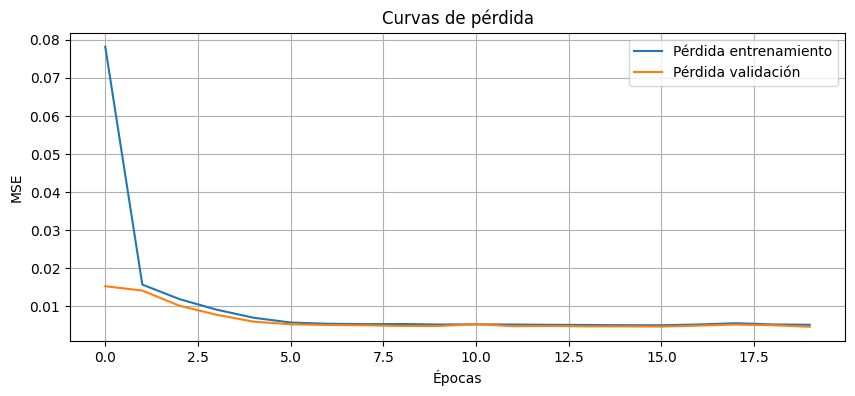

In [5]:
# Curvas de aprendizaje
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.title("Curvas de pérdida")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()


* El modelo ha aprendido correctamente sin caer en sobreajuste (overfitting) ni subajuste (underfitting).

* El uso de validación temprana o EarlyStopping probablemente ayudó a evitar continuar entrenando innecesariamente.

* La similitud entre las curvas indica que los datos de validación provienen de la misma distribución que los de entrenamiento (algo coherente en series temporales correctamente particionadas cronológicamente).

In [7]:
# Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Métricas
rmse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
RMSE: 0.0406
MAE: 0.1619


Esto significa que:

* En promedio, el modelo comete un error absoluto de 0.1619 unidades en la predicción del nivel del río.

* Los errores más grandes contribuyen a un RMSE de 0.0406, lo cual es un valor bajo si consideramos que los datos oscilaban entre aproximadamente -1.5 y +1.5 metros.

**Evaluación del desempeño**

* RMSE	0.0406	Error cuadrático medio bajo (buena precisión)
* MAE	0.1619	Error promedio aceptable en la escala simulada

Ambas métricas indican que el modelo ha aprendido bien los patrones de la serie y puede predecir con buena precisión, especialmente considerando que se trata de datos simulados con ruido.

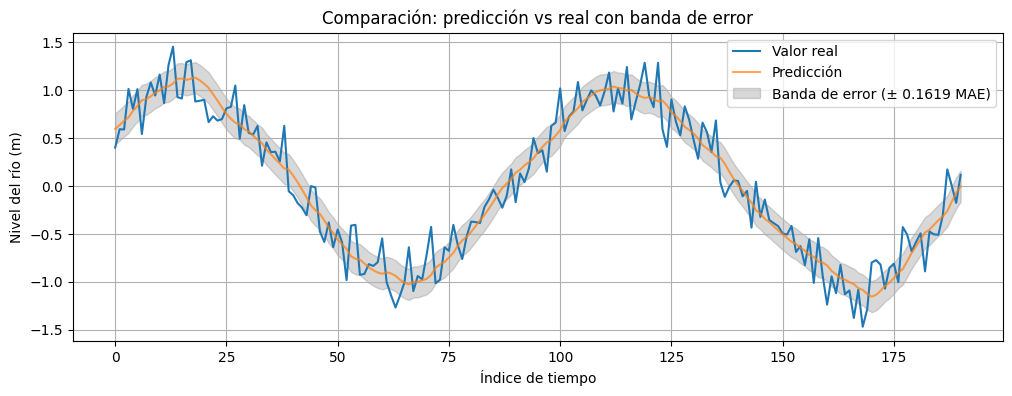

In [11]:
# Comparación gráfica
plt.figure(figsize=(12, 4))
plt.plot(y_test_inv, label='Valor real')
plt.plot(y_pred_inv, label='Predicción', alpha=0.7)

# Agregar bandas de error (por ejemplo, +/- 1.96 * RMSE para un intervalo de confianza del 95% si los errores fueran normales)
# Usaremos MAE como una estimación simple de la magnitud del error típico para las bandas.
error_band = mae  # Puedes ajustar esto o usar RMSE si prefieres
plt.fill_between(range(len(y_test_inv)),
                 (y_pred_inv - error_band).flatten(),
                 (y_pred_inv + error_band).flatten(),
                 color='gray', alpha=0.3, label=f'Banda de error (± {error_band:.4f} MAE)')

plt.title('Comparación: predicción vs real con banda de error')
plt.xlabel("Índice de tiempo")
plt.ylabel("Nivel del río (m)")
plt.legend()
plt.grid(True)
plt.show()

* **Precisión del modelo:**
La mayoría de los valores reales (línea azul) se encuentran dentro de la banda de error (zona gris), lo que indica que el modelo logra predecir correctamente el patrón general de la serie, con una desviación promedio de ±0.1619 m.

* **Tendencia general:**
La curva de predicción (naranja) sigue de manera suave la forma global de la señal, sin intentar capturar todo el ruido o variaciones rápidas, lo que es característico de un modelo que ha aprendido la estructura subyacente y no ha sobreajustado.

* **Diferencias locales:**
Se observan algunas oscilaciones rápidas en la señal real (picos abruptos) que el modelo no reproduce completamente. Esto es esperable, ya que LSTM tiende a suavizar secuencias a menos que se entrene con más complejidad o datos enriquecidos.

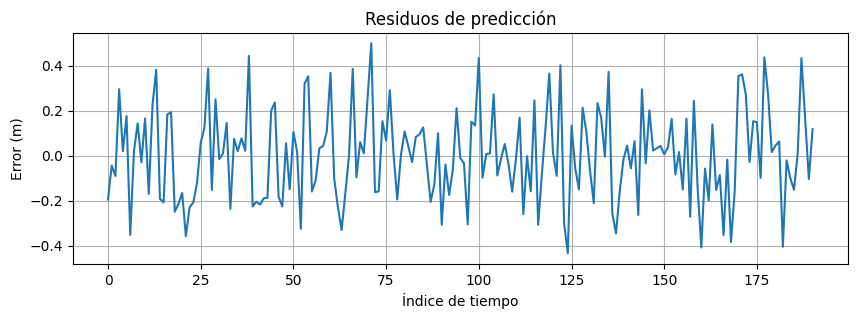

In [9]:
# Gráfico de residuos
residuos = y_test_inv.flatten() - y_pred_inv.flatten()

plt.figure(figsize=(10, 3))
plt.plot(residuos)
plt.title("Residuos de predicción")
plt.xlabel("Índice de tiempo")
plt.ylabel("Error (m)")
plt.grid(True)
plt.show()


* Los residuos oscilan entre aproximadamente -0.4 m y +0.4 m, lo cual es coherente con el valor de MAE (~0.16 m).

* La mayoría de los errores parecen estar centrados alrededor de 0, lo cual indica que no hay sesgo sistemático en las predicciones (el modelo no sobreestima ni subestima constantemente).

* La dispersión es aleatoria y ruidosa, lo cual es una señal positiva de que el modelo captura la tendencia general sin memorizar el ruido.

* No se observan patrones recurrentes (como periodos de sobreestimación o subestimación seguidos), lo cual sugiere que los errores son independientes y no autocorrelacionados, un criterio favorable en la validación de modelos de series temporales.

## Conclusión

Este cuaderno mostró cómo construir un modelo LSTM básico para series temporales en un contexto hidrológico simulado. Algunas recomendaciones clave:

- Validar con divisiones cronológicas, no aleatorias.
- Probar diferentes tamaños de ventana (24, 48, 72 pasos).
- Explorar variantes como GRU o redes híbridas (Conv1D + LSTM).
- Considerar explicabilidad (Grad-CAM temporal o atención).

Este enfoque es aplicable a datos reales del IDEAM para la gestión del riesgo hídrico en Colombia.
